### Setup

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
keras = tf.keras

In [6]:
def plot_series(time, series, format = "-", start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label = label)
    plt.xlabel("Time")
    plt.ylabel("Series")
    if label:
        plt.legend(fontsize = 14)
    plt.grid()
    
def trend(time, slope = 0):
    return time * slope

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(season_time * 2 * np.pi),
                   1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

### Trend and seasonality

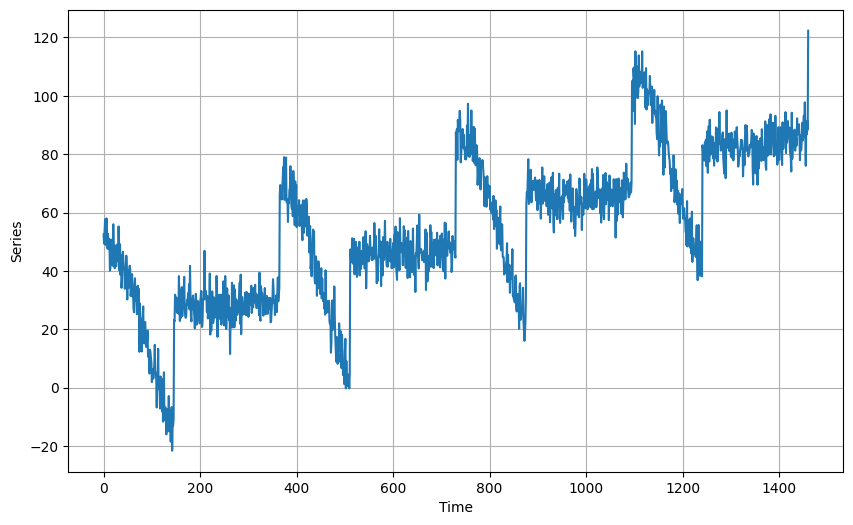

In [7]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed = 42)

series += noise

plt.figure(figsize = (10, 6))
plot_series(time, series)
plt.show()

### Forecasting with machine learning

In [8]:
def window_dataset(series, window_size, batch_size = 32,
                  shuffle_buffer = 1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

x =  [[32.15494132 28.92528864 21.60855625 28.6861381  29.73035225 23.36855413
  28.54108243 28.04865127 22.0284378  29.51843418 30.52015026 33.11873199
  32.96024784 20.79116199 22.97916016 30.23273938 30.21626751 30.21284388
  46.89201954 30.4740562  33.28915439 32.37353457 30.85315469 26.01299416
  31.37779383 23.71289061 26.38745043 25.13970658 27.97132623 39.13112625]]
y =  [18.21782835]


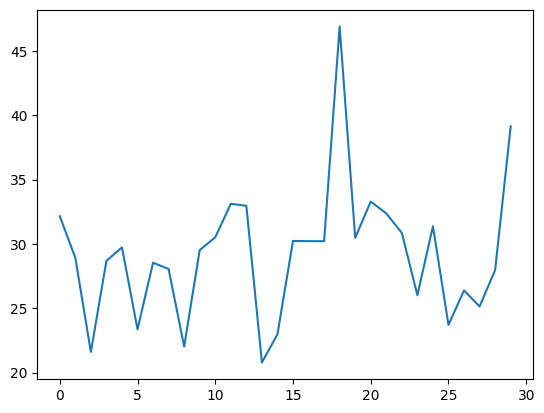

In [21]:
for x, y in window_dataset(series, window_size = 30, batch_size = 1):
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    plt.plot(x.numpy().flatten())
    break

In [22]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear model

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

optimizer = keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

model.fit(train_set, epochs = 100, validation_data = valid_set)

Epoch 1/100
31/31 [==============================] - 1s 10ms/step - loss: 32.4277 - mae: 32.9229 - val_loss: 12.5774 - val_mae: 13.0727
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 8.8321 - mae: 9.3224 - val_loss: 6.2554 - val_mae: 6.7366
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 6.6455 - mae: 7.1282 - val_loss: 8.8759 - val_mae: 9.3671
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 6.2201 - mae: 6.7033 - val_loss: 5.6967 - val_mae: 6.1809
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 5.9902 - mae: 6.4753 - val_loss: 5.9711 - val_mae: 6.4522
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 5.8431 - mae: 6.3279 - val_loss: 5.2715 - val_mae: 5.7504
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 5.3937 - mae: 5.8738 - val_loss: 5.4473 - val_mae: 5.9346
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 5.121

Epoch 63/100
31/31 [==============================] - 0s 5ms/step - loss: 4.4578 - mae: 4.9371 - val_loss: 4.9730 - val_mae: 5.4521
Epoch 64/100
31/31 [==============================] - 0s 5ms/step - loss: 5.0745 - mae: 5.5574 - val_loss: 6.5383 - val_mae: 7.0291
Epoch 65/100
31/31 [==============================] - 0s 4ms/step - loss: 6.4007 - mae: 6.8844 - val_loss: 17.2031 - val_mae: 17.7030
Epoch 66/100
31/31 [==============================] - 0s 4ms/step - loss: 6.0758 - mae: 6.5590 - val_loss: 5.7922 - val_mae: 6.2811
Epoch 67/100
31/31 [==============================] - 0s 5ms/step - loss: 4.5989 - mae: 5.0782 - val_loss: 4.4299 - val_mae: 4.9018
Epoch 68/100
31/31 [==============================] - 0s 5ms/step - loss: 4.6971 - mae: 5.1768 - val_loss: 4.5820 - val_mae: 5.0580
Epoch 69/100
31/31 [==============================] - 0s 4ms/step - loss: 4.7608 - mae: 5.2392 - val_loss: 6.2225 - val_mae: 6.7124
Epoch 70/100
31/31 [==============================] - 0s 5ms/step - loss: 

#### Find the best learning rate

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
# valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10 ** (epoch / 30))

optimizer = keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9)

model.compile(loss = keras.losses.Huber(),
             metrics = ['mae'],
             optimizer = optimizer)

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 14.0853 - mae: 14.5795 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 10.4216 - mae: 10.9068 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 9.9322 - mae: 10.4181 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 9.8574 - mae: 10.3421 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 9.7922 - mae: 10.2769 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 9.7163 - mae: 10.2016 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 9.6442 - mae: 10.1299 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 9.5580 - mae: 10.0450 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 9.4709 - mae: 9.9580 - lr: 1.

31/31 [==============================] - 0s 2ms/step - loss: 6.9574 - mae: 7.4451 - lr: 2.7123e-04
Epoch 75/100
31/31 [==============================] - 0s 3ms/step - loss: 7.0250 - mae: 7.5044 - lr: 2.9286e-04
Epoch 76/100
31/31 [==============================] - 0s 2ms/step - loss: 10.3760 - mae: 10.8648 - lr: 3.1623e-04
Epoch 77/100
31/31 [==============================] - 0s 2ms/step - loss: 10.4325 - mae: 10.9232 - lr: 3.4145e-04
Epoch 78/100
31/31 [==============================] - 0s 2ms/step - loss: 13.4542 - mae: 13.9453 - lr: 3.6869e-04
Epoch 79/100
31/31 [==============================] - 0s 2ms/step - loss: 8.9258 - mae: 9.4166 - lr: 3.9811e-04
Epoch 80/100
31/31 [==============================] - 0s 3ms/step - loss: 10.7036 - mae: 11.1925 - lr: 4.2987e-04
Epoch 81/100
31/31 [==============================] - 0s 2ms/step - loss: 17.4417 - mae: 17.9334 - lr: 4.6416e-04
Epoch 82/100
31/31 [==============================] - 0s 3ms/step - loss: 20.5333 - mae: 21.0282 - lr: 5.01

#### Plot losses as learning rate changes in every 30 epochs

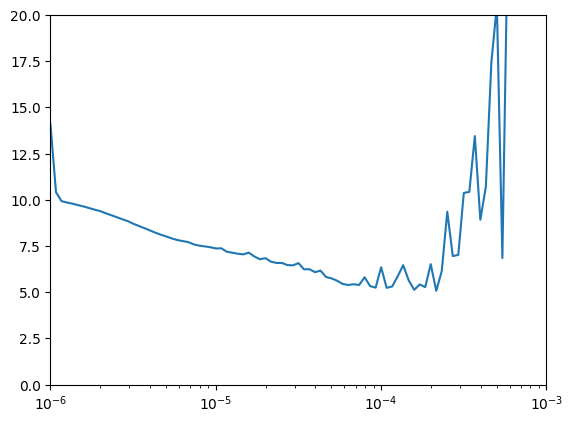

In [34]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3,0, 20])
plt.show()

#### Early stopping

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape = [window_size])
])

optimizer = keras.optimizers.SGD(learning_rate = 1e-5, momentum = .9)

model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 10)

history = model.fit(train_set, epochs = 500,
                    validation_data = valid_set,
                    callbacks = [early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 40.2453 - mae: 40.7414 - val_loss: 21.4632 - val_mae: 21.9631
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 9.7736 - mae: 10.2627 - val_loss: 8.2647 - val_mae: 8.7534
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 8.2470 - mae: 8.7357 - val_loss: 7.7939 - val_mae: 8.2806
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 7.7672 - mae: 8.2548 - val_loss: 7.7176 - val_mae: 8.2026
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 7.5007 - mae: 7.9844 - val_loss: 7.4399 - val_mae: 7.9272
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 7.2101 - mae: 7.6930 - val_loss: 7.0550 - val_mae: 7.5405
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 6.9978 - mae: 7.4839 - val_loss: 7.1562 - val_mae: 7.6396
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 6.94

31/31 [==============================] - 0s 5ms/step - loss: 5.0687 - mae: 5.5489 - val_loss: 5.3024 - val_mae: 5.7776
Epoch 64/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0504 - mae: 5.5275 - val_loss: 5.2840 - val_mae: 5.7587
Epoch 65/500
31/31 [==============================] - 0s 4ms/step - loss: 5.0203 - mae: 5.4976 - val_loss: 5.3066 - val_mae: 5.7842
Epoch 66/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0276 - mae: 5.5038 - val_loss: 5.3181 - val_mae: 5.7963
Epoch 67/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0349 - mae: 5.5115 - val_loss: 5.2495 - val_mae: 5.7285
Epoch 68/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0596 - mae: 5.5401 - val_loss: 5.3445 - val_mae: 5.8237
Epoch 69/500
31/31 [==============================] - 0s 5ms/step - loss: 5.0494 - mae: 5.5277 - val_loss: 5.2234 - val_mae: 5.7039
Epoch 70/500
31/31 [==============================] - 0s 5ms/step - loss: 4.9994 - mae: 5

Epoch 125/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5184 - mae: 4.9926 - val_loss: 4.9084 - val_mae: 5.3864
Epoch 126/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5119 - mae: 4.9884 - val_loss: 4.7275 - val_mae: 5.2046
Epoch 127/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5086 - mae: 4.9895 - val_loss: 4.9483 - val_mae: 5.4192
Epoch 128/500
31/31 [==============================] - 0s 5ms/step - loss: 4.5323 - mae: 5.0056 - val_loss: 4.9742 - val_mae: 5.4558
Epoch 129/500
31/31 [==============================] - 0s 4ms/step - loss: 4.5090 - mae: 4.9846 - val_loss: 4.7257 - val_mae: 5.1996
Epoch 130/500
31/31 [==============================] - 0s 4ms/step - loss: 4.4777 - mae: 4.9537 - val_loss: 4.9873 - val_mae: 5.4697
Epoch 131/500
31/31 [==============================] - 0s 6ms/step - loss: 4.6253 - mae: 5.0999 - val_loss: 4.7242 - val_mae: 5.1998
Epoch 132/500
31/31 [==============================] - 0s 6ms/step - 

31/31 [==============================] - 0s 5ms/step - loss: 4.3828 - mae: 4.8583 - val_loss: 4.8554 - val_mae: 5.3349
Epoch 187/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3348 - mae: 4.8146 - val_loss: 4.9913 - val_mae: 5.4686
Epoch 188/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4195 - mae: 4.8954 - val_loss: 4.6103 - val_mae: 5.0901
Epoch 189/500
31/31 [==============================] - 0s 5ms/step - loss: 4.4249 - mae: 4.8985 - val_loss: 4.6647 - val_mae: 5.1456
Epoch 190/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3642 - mae: 4.8376 - val_loss: 4.7239 - val_mae: 5.1964
Epoch 191/500
31/31 [==============================] - 0s 5ms/step - loss: 4.3584 - mae: 4.8332 - val_loss: 4.5760 - val_mae: 5.0540
